**Summary**: Built a neural network consisting of VGG19 architecture + simple feed forward to classify crops in a [kaggle](https://www.kaggle.com/aman2000jaiswal/agriculture-crop-images) dataset. This system has been built for predictions (see below), however, to optimize its usecase, the dataset must be switched from general crop images to weeds in crops so the neural network can detect if an area has weeds or not.

# Imports

In [2]:
import numpy as np 
import pandas as pd
import os
import tensorflow as tf 
import keras 
from keras.applications import VGG19
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import cv2

Using TensorFlow backend.


# Process / Organize Data

In [3]:
df = []

crops = ['jute', 'maize', 'rice', 'sugarcane', 'wheat']

# Useful dict for switching between crop names and labels
crop_to_label = {}
for i, crop in enumerate(crops):
    crop_to_label[crop] = i
    
label_to_crop = {value:key for (key, value) in crop_to_label.items()}

for crop in crops:
    subdir = 'D:/ML_Data/agriculture_crop_images/kag2/' + crop
    for path in os.listdir(subdir):
        df.append([os.path.join(subdir, path), crop])
    
df = pd.DataFrame(df, columns=['path', 'label'])
df = df.sample(frac=1, random_state=0).reset_index(drop=True) # shuffle the rows
df.head()

,path,label
0,D:/ML_Data/agriculture_crop_images/kag2/jute\j...,jute
1,D:/ML_Data/agriculture_crop_images/kag2/sugarc...,sugarcane
2,D:/ML_Data/agriculture_crop_images/kag2/sugarc...,sugarcane
3,D:/ML_Data/agriculture_crop_images/kag2/jute\j...,jute
4,D:/ML_Data/agriculture_crop_images/kag2/maize\...,maize


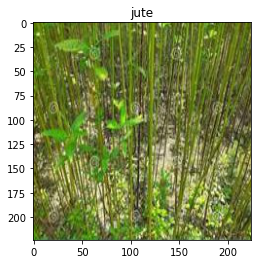

In [4]:
# Function to process images for quicker use
def preprocess_image(path):
    im = plt.imread(path)
    im = cv2.resize(im, (224,224), interpolation=cv2.INTER_CUBIC)    
    return im/255.

# Test on first image in dataset
im = preprocess_image(df.loc[0, 'path'])
label = df.loc[0, 'label']

# Get the image dimensions to a variable
img_size, _, channels = im.shape

# Show the image with its label
plt.title(label)
plt.imshow(im)
plt.show()

In [5]:
n_examples = len(df.index)
n_classes = len(crops)

# Initialize X and y
X = np.zeros(shape=(n_examples, img_size, img_size, channels))
y = np.zeros(shape=(n_examples, n_classes))

# Loop through dataset to set values of X and y
for i, idx in enumerate(df.index):
    path, label = df.loc[idx, :]
    X[i, :, :, :] = preprocess_image(path)
    y[i, crop_to_label[label]] = 1

In [6]:
X_train, X_dev, y_train, y_dev = train_test_split(X, y, test_size=0.2, random_state=0)

# Build Model

In [7]:
num_classes = 5

model = Sequential()
vgg = VGG19(input_shape=(img_size,img_size,channels),include_top=False,weights = 'imagenet',pooling='avg')
model.add(vgg)
model.add(Dense(1000, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(num_classes, activation='softmax'))

model.layers[0].trainable = False

In [8]:
batch_size = 16
epochs = 30
learning_rate = 1e-3
model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate, decay=learning_rate/epochs), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 512)               20024384  
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              513000    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               128128    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 20,666,157
Trainable params: 641,773
Non-trainable params: 20,024,384
_________________________________________________________________


# Train Model

In [10]:
history = model.fit(x=X_train, y=y_train, validation_data=(X_dev, y_dev), epochs=epochs, batch_size=batch_size)

Train on 643 samples, validate on 161 samples
Epoch 1/30
643/643 [==============================] - 9s 15ms/step - loss: 1.5730 - accuracy: 0.2955 - val_loss: 1.4204 - val_accuracy: 0.4224
Epoch 2/30
643/643 [==============================] - 6s 10ms/step - loss: 1.2513 - accuracy: 0.5054 - val_loss: 1.2285 - val_accuracy: 0.4658
Epoch 3/30
643/643 [==============================] - 6s 10ms/step - loss: 1.0554 - accuracy: 0.5832 - val_loss: 1.0389 - val_accuracy: 0.5776
Epoch 4/30
643/643 [==============================] - 6s 10ms/step - loss: 0.8729 - accuracy: 0.6967 - val_loss: 0.9530 - val_accuracy: 0.5901
Epoch 5/30
643/643 [==============================] - 6s 10ms/step - loss: 0.7359 - accuracy: 0.7496 - val_loss: 0.7260 - val_accuracy: 0.7764
Epoch 6/30
643/643 [==============================] - 6s 10ms/step - loss: 0.6327 - accuracy: 0.7652 - val_loss: 0.7355 - val_accuracy: 0.6957
Epoch 7/30
643/643 [==============================] - 7s 10ms/step - loss: 0.5057 - accuracy: 0.

In [11]:
model

In [12]:
model.save('models/first_seq.h5')

# Get Metrics

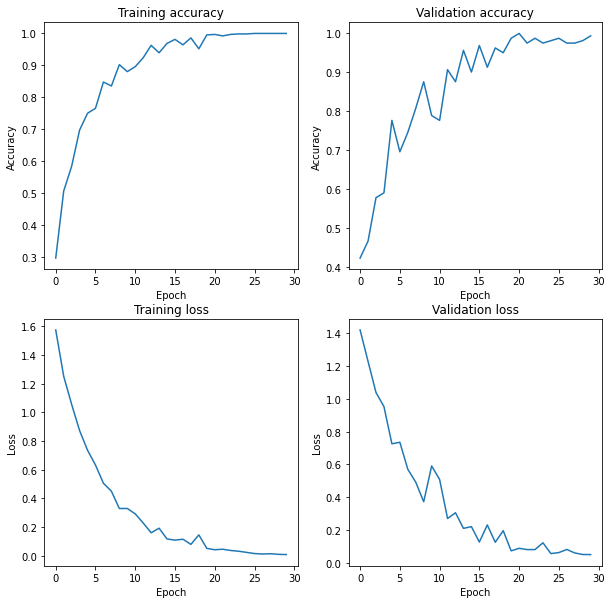

In [13]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.title('Training accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'])

plt.subplot(2, 2, 2)
plt.title('Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(history.history['val_accuracy'])

plt.subplot(2, 2, 3)
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.history['loss'])

plt.subplot(2, 2, 4)
plt.title('Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(history.history['val_loss'])

plt.show()

# Predict Images from Dataset

In [44]:
def predict_from_dataset(x):
    test_img = X_dev[x]
    plt.imshow(test_img)
    print('Prediction:', crops[np.argmax(model.predict(np.expand_dims(test_img, axis=0)))])


Prediction: wheat


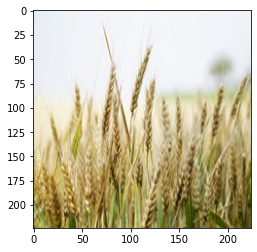

In [45]:
predict_from_dataset(0)


Prediction: maize


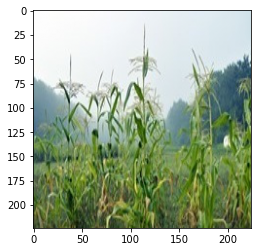

In [46]:
predict_from_dataset(32)


Prediction: wheat


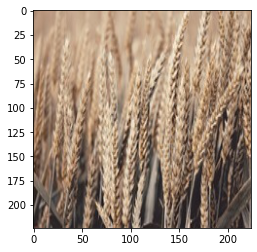

In [47]:
predict_from_dataset(15)

# Predict Unknown Images from the Internet

In [110]:
from PIL import Image
def predict_image(x):
    img1 = Image.open(x).convert(mode="RGB")
    img1 = img1.resize((224,224))
    array1 = np.array(img1.getdata())
    img_np_array = np.reshape(array1, (224,224,3)) / 255

    plt.imshow(img_np_array)
    a = np.expand_dims(img_np_array, axis=0)
    print('Prediction:', crops[np.argmax(model.predict(a))])

Prediction: rice


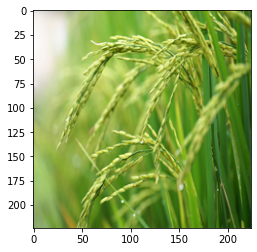

In [111]:
predict_image('test_images/crop1.jpg')

Prediction: wheat


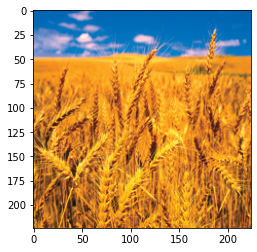

In [112]:
predict_image('test_images/crop2.jpg')

Prediction: maize


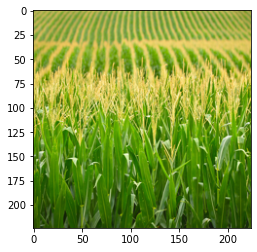

In [113]:
predict_image('test_images/crop3.jpg')

Prediction: jute


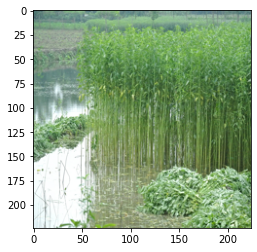

In [114]:
predict_image('test_images/crop4.jpg')

Prediction: wheat


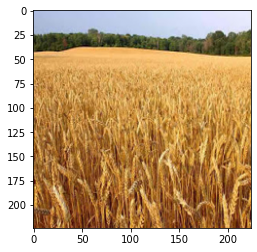

In [115]:
predict_image('test_images/crop5.jpg')

Prediction: maize


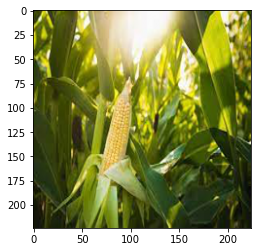

In [116]:
predict_image('test_images/crop6.jpg')

Prediction: sugarcane


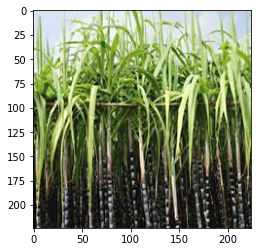

In [117]:
predict_image('test_images/crop7.jpg')

Prediction: jute


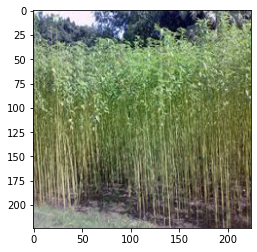

In [118]:
predict_image('test_images/crop8.jpg')

Prediction: jute


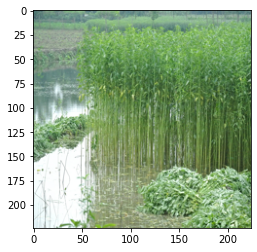

In [119]:
predict_image('test_images/crop4.jpg')